In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
              auc, mean_squared_error, accuracy_score
import math
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

# 1. Осмотр данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [4]:
df['type_school'].value_counts()

Academic      609
Vocational    391
Name: type_school, dtype: int64

In [5]:
# Видим что пропущенных значений нет, также есть числовые, категориальные и бинарные данные. 
# Причем думаю что если целевую переменную (in_college) можно преобразовать в 0 и 1, то переменную "parent_was_in_college"
# нужно преобразовывать категориально

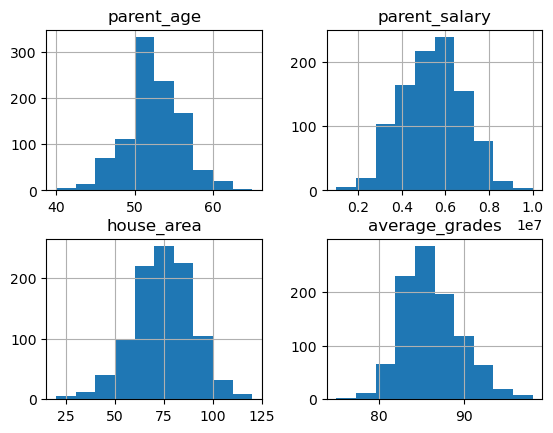

In [6]:
df.hist();

# 2. Создание пайплайна для предобработки

In [7]:
# Target variable extraction
x = df.drop(['in_college'], axis = 1)
y = df['in_college'].astype(int)

In [12]:
# Create lists of numeric and categorical features  
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object', 'bool']).columns

In [9]:
numeric_features, categorical_features

(Index(['parent_age', 'parent_salary', 'house_area', 'average_grades'], dtype='object'),
 Index(['type_school', 'school_accreditation', 'gender', 'interest',
        'residence', 'parent_was_in_college'],
       dtype='object'))

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=42)

In [11]:
# Create a numeric and categorical transformer to perform preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [12]:
# Use the ColumnTransformer to apply to the correct features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 3. Решение задачи классификации

### 3.1 Методом логистической регрессии

In [13]:
# Append regressor to the preprocessor
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LogisticRegression())])

In [14]:
cross_validate(lr, X_train, y_train)

{'fit_time': array([0.02393532, 0.02194452, 0.02197027, 0.01293182, 0.01498818]),
 'score_time': array([0.00698209, 0.00398588, 0.0039897 , 0.00302124, 0.00495982]),
 'test_score': array([0.80666667, 0.9       , 0.89333333, 0.86      , 0.80666667])}

In [15]:
lr_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
lr_score

array([0.9034495 , 0.96426031, 0.95003556, 0.93154339, 0.92763158])

In [16]:
lr_score.mean(), lr_score.std()

(0.9353840682788052, 0.02070348869470884)

In [17]:
# Fit the complete pipeline
lr.fit(X_train, y_train)
print("model score: %.3f" % lr.score(X_test, y_test))

model score: 0.856


### 3.2 Методом линейной классификации (Стохастический поиск)

In [18]:
SGDclf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', SGDClassifier())])

In [19]:
cross_validate(SGDclf, X_train, y_train)

{'fit_time': array([0.01000142, 0.01000404, 0.00798297, 0.00898075, 0.00897956]),
 'score_time': array([0.00395989, 0.00299239, 0.00398469, 0.00295949, 0.00398922]),
 'test_score': array([0.78666667, 0.86666667, 0.9       , 0.78666667, 0.80666667])}

In [20]:
SGDclf_score = cross_val_score(SGDclf, X_train, y_train, cv=5, scoring='roc_auc')
SGDclf_score

array([0.88815789, 0.95590327, 0.94576814, 0.91678521, 0.91056188])

In [21]:
SGDclf_score.mean(), SGDclf_score.std()

(0.9234352773826459, 0.02452496216500272)

In [22]:
SGDclf.fit(X_train, y_train)
print("model score: %.3f" % SGDclf.score(X_test, y_test))

model score: 0.836


### 3.3 Деревом решений

In [23]:
Tree_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', DecisionTreeClassifier())])

In [24]:
cross_validate(Tree_clf, X_train, y_train)

{'fit_time': array([0.0099721 , 0.00899005, 0.00898147, 0.00897694, 0.00798273]),
 'score_time': array([0.00398827, 0.00397515, 0.00398946, 0.00398374, 0.00398397]),
 'test_score': array([0.78      , 0.82      , 0.85333333, 0.84      , 0.8       ])}

In [25]:
Tree_clf_score = cross_val_score(Tree_clf, X_train, y_train, cv=5, scoring='roc_auc')
Tree_clf_score

array([0.76066856, 0.82734708, 0.8598862 , 0.82681366, 0.80618777])

In [26]:
Tree_clf_score.mean(), Tree_clf_score.std()

(0.8161806543385491, 0.03264774056242014)

In [27]:
Tree_clf.fit(X_train, y_train)
print("model score: %.3f" % Tree_clf.score(X_test, y_test))

model score: 0.864


### 3.4 Методом опорных векторов

In [28]:
SVM_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearSVC())])

In [29]:
cross_validate(SVM_clf, X_train, y_train)

{'fit_time': array([0.01495957, 0.01495957, 0.01296616, 0.01297235, 0.01496673]),
 'score_time': array([0.00399017, 0.00398922, 0.00302339, 0.00398707, 0.00298691]),
 'test_score': array([0.79333333, 0.89333333, 0.90666667, 0.85333333, 0.79333333])}

In [30]:
SVM_clf_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
SVM_clf_score

array([0.9034495 , 0.96426031, 0.95003556, 0.93154339, 0.92763158])

In [31]:
SVM_clf_score.mean(), SVM_clf_score.std()

(0.9353840682788052, 0.02070348869470884)

In [32]:
SVM_clf.fit(X_train, y_train)
print("model score: %.3f" % SVM_clf.score(X_test, y_test))

model score: 0.860


# 4. Cравним полученные в каждом решении метрики между собой

In [33]:
# 4.1 Логистическая регрессия

In [34]:
lr_pred = lr.predict(X_test)

In [35]:
confusion_matrix(y_test, lr_pred)

array([[109,  21],
       [ 15, 105]], dtype=int64)

In [36]:
precision_score(y_test, lr_pred), recall_score(y_test, lr_pred), f1_score(y_test, lr_pred), roc_auc_score(y_test, lr_pred)

(0.8333333333333334, 0.875, 0.8536585365853658, 0.8567307692307692)

In [37]:
# 4.2 Линейная классификация (Стохастический поиск)

In [38]:
SGD_pred = SGDclf.predict(X_test)

In [39]:
confusion_matrix(y_test, SGD_pred)

array([[114,  16],
       [ 25,  95]], dtype=int64)

In [40]:
precision_score(y_test, SGD_pred), recall_score(y_test, SGD_pred), f1_score(y_test, SGD_pred), roc_auc_score(y_test, SGD_pred)

(0.8558558558558559,
 0.7916666666666666,
 0.8225108225108225,
 0.8342948717948717)

In [41]:
# 4.3 Дерево решений

In [42]:
Tree_pred = Tree_clf.predict(X_test)

In [43]:
confusion_matrix(y_test, Tree_pred)

array([[115,  15],
       [ 19, 101]], dtype=int64)

In [44]:
precision_score(y_test, Tree_pred), recall_score(y_test, Tree_pred), f1_score(y_test, Tree_pred), roc_auc_score(y_test, Tree_pred)

(0.8706896551724138,
 0.8416666666666667,
 0.8559322033898306,
 0.8631410256410257)

In [45]:
# 4.4 Метод опорных векторов

In [46]:
SVM_pred = SVM_clf.predict(X_test)

In [47]:
confusion_matrix(y_test, SVM_pred)

array([[109,  21],
       [ 14, 106]], dtype=int64)

In [48]:
precision_score(y_test, SVM_pred), recall_score(y_test, SVM_pred), f1_score(y_test, SVM_pred), roc_auc_score(y_test, SVM_pred)

(0.8346456692913385, 0.8833333333333333, 0.8582995951417004, 0.860897435897436)

In [49]:
# В целом все модели отработали хорошо, результаты примерно одинаковые.

# 5. GridSearch для поиска оптимальных гиперпараметров, перечисленных выше алгоритмов.

In [52]:
from sklearn.model_selection import GridSearchCV

### 5.1 Поиск для логистической регрессии

In [65]:
lr_params = {"regressor__C": [0.01, 0.1, 1, 10], "regressor__penalty": ["l1", "l2"], 
             "regressor__solver": ["liblinear"]}

In [66]:
lr_grid = GridSearchCV(lr, lr_params, cv=5, verbose=True, scoring='roc_auc' )

In [67]:
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['parent_age', 'parent_salary', 'house_area', 'average_grades'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                 

In [68]:
lr_grid.best_params_

{'regressor__C': 1,
 'regressor__penalty': 'l2',
 'regressor__solver': 'liblinear'}

In [69]:
lr_grid.best_score_

0.9353840682788052

In [70]:
pred_lr = lr_grid.predict(X_test)

In [71]:
roc_auc_score(y_test, pred_lr), accuracy_score(y_test, pred_lr)

(0.8567307692307692, 0.856)

In [73]:
print(f'У базовой реализации логистической регрессии roc_auc_score был: {roc_auc_score(y_test, lr_pred)}')

У базовой реализации логистической регрессии roc_auc_score был: 0.8567307692307692


In [ ]:
# Вывод: Базовая реализация логистической регрессии работает хорошо.

### 5.2 Поиск для линейной классификации (Стохастического поиска)

In [74]:
SGD_params = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [75]:
SGD_grid = GridSearchCV(SGDclf, SGD_params, cv=5, verbose=True, scoring='roc_auc' )

In [76]:
SGD_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['parent_age', 'parent_salary', 'house_area', 'average_grades'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                 

In [77]:
SGD_grid.best_params_

{'regressor__alpha': 0.01}

In [78]:
SGD_grid.best_score_

0.9320768136557611

In [79]:
pred_SGD = SGD_grid.predict(X_test)

In [80]:
roc_auc_score(y_test, pred_SGD), accuracy_score(y_test, pred_SGD)

(0.8567307692307692, 0.856)

In [81]:
print(f'У базовой реализации cтохастического поиска roc_auc_score был: {roc_auc_score(y_test, SGD_pred)}')

У базовой реализации cтохастического поиска roc_auc_score был: 0.8342948717948717


In [ ]:
# Вывод: GridSearch показал немного лучший результат у cтохастического поиска чем из коробки

### 5.3 Поиск для дерева

In [83]:
tree_params = {'regressor__max_depth': np.arange(1,11), 'regressor__max_features': np.arange(3,19)}

In [84]:
tree_grid = GridSearchCV(Tree_clf, tree_params, cv=5, verbose=True, scoring='roc_auc' )

In [85]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['parent_age', 'parent_salary', 'house_area', 'average_grades'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                 

In [86]:
tree_grid.best_params_

{'regressor__max_depth': 5, 'regressor__max_features': 17}

In [87]:
tree_grid.best_score_

0.8979196301564721

In [91]:
pred_tree = tree_grid.predict(X_test)

In [92]:
roc_auc_score(y_test, pred_tree), accuracy_score(y_test, pred_tree)

(0.8717948717948718, 0.872)

In [93]:
print(f'У базовой реализации дерева решений roc_auc_score был: {roc_auc_score(y_test, Tree_pred)}')

У базовой реализации дерева решений roc_auc_score был: 0.8631410256410257


In [94]:
# Вывод: GridSearch показал немного лучший результат у дерева решений чем из коробки

### 5.4 Поиск для метода опорных векторов

In [95]:
SVM_params = {"regressor__C": [0.01, 0.1, 1, 10], "regressor__penalty": ["l1", "l2"], 
              "regressor__dual": [False]}

In [96]:
SVM_grid = GridSearchCV(SVM_clf, SVM_params, cv=5, verbose=True, scoring='roc_auc' )

In [97]:
SVM_grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['parent_age', 'parent_salary', 'house_area', 'average_grades'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                 

In [98]:
SVM_grid.best_params_

{'regressor__C': 1, 'regressor__dual': False, 'regressor__penalty': 'l1'}

In [99]:
SVM_grid.best_score_

0.935348506401138

In [100]:
pred_SVM = SVM_grid.predict(X_test)

In [101]:
roc_auc_score(y_test, pred_SVM), accuracy_score(y_test, pred_SVM)

(0.860897435897436, 0.86)

In [102]:
print(f'У базовой реализации дерева решений roc_auc_score был: {roc_auc_score(y_test, SVM_pred)}')

У базовой реализации дерева решений roc_auc_score был: 0.860897435897436


In [103]:
# Вывод: Базовая реализация метода опорных векторов работает хорошо.